In [1]:
import matplotlib.pyplot as plt
import torch
from torch.distributions import MultivariateNormal, Normal
import matplotlib as mpl

In [2]:
prior = Normal(0, 1)
t = prior.sample((300,))
x = t ** 2 + prior.sample((300,))*0.5

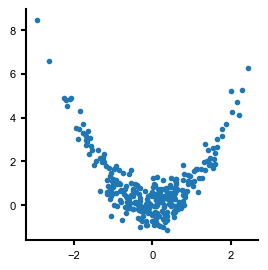

In [3]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.scatter(t.numpy(), x.numpy())
    plt.savefig("../svg/panel_b.svg")